In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# device = 'cpu'
# import os


PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU count: 1
Using device: cuda


### Load dataset

In [2]:
from datasets import load_dataset
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Load the entire dataset
ds = load_dataset("argilla/cnn-dailymail-summaries", split='train')
print(ds)

Dataset({
    features: ['article', 'highlights', 'id', 'summary', 'distilabel_metadata', 'model_name'],
    num_rows: 287113
})


### Tokenize inputs and targets

In [3]:
# Tokens <s> and </s> are added from default in BartTokenizer
# Padding was required due to different size of inputs (each article is different): https://huggingface.co/docs/transformers/en/

val = 2 ** 16
# val = 2 ** 6
print(val)
inputs = tokenizer(ds['article'][:val], padding='longest', truncation=True, max_length=1024)['input_ids']
targets = tokenizer(ds['highlights'][:val], padding='longest', truncation=True, max_length=128)[
    'input_ids']  # --> padding to the longest text but shorter or equal max_len (128)
print(tokenizer.decode(inputs[0]))
print(tokenizer.decode(targets[0]))

# inputs = torch.tensor(inputs)
# targets = torch.tensor(targets)
# Efficient conversion to CUDA tensors
inputs = torch.as_tensor(inputs, device=device)
targets = torch.as_tensor(targets, device=device)
print(inputs.size())
print(targets.size())

max_input_seq = inputs.size(1)
max_output_seq = targets.size(1)
# max_input_seq = 1024
# max_output_seq = 128
print(f'Max input seq: {max_input_seq}')
print(f"Max output seq: {max_output_seq}")
vocab_size = tokenizer.VOCAB_SIZE
print(f'Vocab size: {vocab_size}')

65536
<s>Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how he'll mark his land

In [4]:
batch_size = 32

### Create custom dataset

In [5]:
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)


class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


inputs = inputs.to(device)
targets = targets.to(device)
dataset = CustomDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# for x, y in dataloader:
#   print(f"Inputs: {x.size()}, Targets: {y.size()}")

num_batches = len(dataloader)
print(f"Num batches: {num_batches}")

Num batches: 2048


![](images/transformer_architecture.png)


### Functions to generate masks for:
- encoder multi-head
- decoder masked multi-head
- decoder multi-head (cross attention)

In [6]:
def get_padding_mask(idx: torch.Tensor, tgt_size, src_size):
    mask = (idx != tokenizer.pad_token_id).bool()
    mask = mask.unsqueeze(1).expand(-1, tgt_size, src_size).unsqueeze(1).to(device)  # (batch_size, seq_len, seq_len)
    return mask


def get_tgt_mask(idy: torch.Tensor):
    mask = torch.triu(torch.ones(idy.size(1), idy.size(1)).bool(), diagonal=1).logical_not()
    mask = mask.expand(idy.size(0), -1, -1).unsqueeze(1).to(device)
    return mask

In [7]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        """
        q, k, v: (N, H, L, E - batch_size, n_heads, seq_len, head_dim)
        mask: (N, L, S - batch_size, tgt_seq_len, src_seq_len)
        """
        batch_size, max_sequence_length, d_model = x.size()  # B,T,C

        # print('Mask:', mask.shape)
        qkv = self.qkv_layer(x)  # B,T,C=C*3
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads,
                          3 * self.head_dim)  # B,T,N_HEADS,C=DIM//N_HEADS*3
        qkv = qkv.permute(0, 2, 1, 3)  # permute swaps the places
        q, k, v = qkv.chunk(3, dim=-1)  # B,N_HEADS,T,C=C/3
        values = F.scaled_dot_product_attention(q, k, v, mask)  # B,T,N_HEADS,C
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)  # B,T,C
        out = self.linear_layer(values)
        return out

### Encoder

In [8]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, dropout):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.GELU(approximate='tanh'),
            nn.Linear(ffn_hidden, d_model))
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        residual_x = x
        # print("------- ATTENTION 1 ------")
        x = self.attention(x, src_mask)
        # print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        # print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        # print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        # print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        # print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_input_seq):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.input_emb = nn.Embedding(vocab_size, d_model,
                                      device=device)  # embeddings for max 50265 tokens with emb_dim dimension
        self.pos_emb = nn.Embedding(max_input_seq, d_model,
                                    device=device)  # positional encoding (max_input_seq is the biggest article in input)
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, ffn_hidden, num_heads, dropout).to(device) for _ in range(num_layers)])

    def forward(self, x, src_mask=None):
        B, T = x.shape  # Batch size and sequence length

        # Token embeddings
        input_embeddings = self.input_emb(x)  # Shape: [B, T, emb_dim]

        # Positional embeddings
        positions = torch.arange(0, T, device=x.device)
        positions = positions.unsqueeze(0)  # Shape: [1, T]

        positional_embeddings = self.pos_emb(positions)  # Shape: [1, T, emb_dim]

        # Combine token and positional embeddings
        x = input_embeddings + positional_embeddings  # Shape: [B, T, emb_dim]
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

In [9]:
class CrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model, 2 * d_model)  # 1024
        self.q_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask=None):
        """
        q: (N, H, L, E - batch_size, n_heads, tgt_seq_len, head_dim)
        kv: (N, H, S, E - batch_size, n_heads, src_seq_len, head_dim)
        mask: (N, L, S - batch_size, tgt_seq_len, src_seq_len)
        """
        batch_size, sequence_length, d_model = x.size()  # x (encoder output)
        _, target_sequence_length, _ = y.size()  # y (decoder input)
        kv = self.kv_layer(x)
        q = self.q_layer(y)

        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, target_sequence_length, self.num_heads, self.head_dim)  # Use target_sequence_length
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)

        values = F.scaled_dot_product_attention(q, k, v, mask)
        values = values.reshape(batch_size, target_sequence_length, d_model)
        out = self.linear_layer(values)
        return out

### Decoder

In [10]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.cross_attention = CrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.GELU(approximate='tanh'),
            nn.Linear(ffn_hidden, d_model))
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, encoder_output, y, tgt_mask=None, cross_mask=None):
        residual_y = y
        # print("MASKED SELF ATTENTION")
        y = self.self_attention(y, mask=tgt_mask)
        # print("DROP OUT 1")
        y = self.dropout1(y)
        # print("ADD + LAYER NORMALIZATION 1")
        y = self.norm1(y + residual_y)
        residual_y = y
        # print("CROSS ATTENTION")
        y = self.cross_attention(encoder_output, y, cross_mask)
        # print("DROP OUT 2")
        y = self.dropout2(y)
        # print("ADD + LAYER NORMALIZATION 2")
        y = self.norm2(y + residual_y)
        residual_y = y
        # print("FEED FORWARD 1")
        y = self.ffn(y)
        # print("DROP OUT 3")
        y = self.dropout3(y)
        # print("ADD + LAYER NORMALIZATION 3")
        y = self.norm3(y + residual_y)
        return y


class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_output_seq):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.output_emb = nn.Embedding(vocab_size, d_model,
                                       device=device)
        self.pos_emb = nn.Embedding(max_output_seq, d_model,
                                    device=device)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, ffn_hidden, num_heads, dropout).to(device) for _ in range(num_layers)])

    def forward(self, x, encoder_output, tgt_mask=None, cross_mask=None):
        B, T = x.shape  # Batch size and sequence length

        # Token embeddings
        output_embeddings = self.output_emb(x)  # Shape: [B, T, emb_dim]

        # Positional embeddings
        positions = torch.arange(0, T, device=x.device)
        positions = positions.unsqueeze(0)  # Shape: [1, T]

        positional_embeddings = self.pos_emb(positions)  # Shape: [1, T, emb_dim]

        # Combine token and positional embeddings
        x = output_embeddings + positional_embeddings  # Shape: [B, T, emb_dim]
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(encoder_output, x, tgt_mask, cross_mask)
        return x

### Parameters

In [11]:
d_model = 512
num_heads = 8
dropout = 0.1
ffn_hidden = d_model * 4
num_layers = 6

### Transformer model

In [12]:
class MyTransformer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_output_seq, max_input_seq):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_input_seq)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_output_seq)
        self.ln_final = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, inputs, targets, src_mask=None, tgt_mask=None, cross_mask=None):
        encoder_output = self.encoder(inputs, src_mask=src_mask)
        out = self.decoder(targets, encoder_output, tgt_mask=tgt_mask, cross_mask=cross_mask)
        out = self.ln_final(out)
        logits = self.lm_head(out)
        return logits



In [13]:
transformer = MyTransformer(d_model, ffn_hidden, num_heads, dropout, num_layers, vocab_size, max_output_seq,
                            max_input_seq)
transformer = transformer.to(device)

### Training

In [14]:
torch.manual_seed(42)
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm  # For a progress bar

# Hyperparameters
lr_history = []
loss_history = []

learning_rate = 3e-4
# gradient_accumulation_steps = 1  # Optional, to simulate larger batches
# max_grad_norm = 1.0
# num_epochs = 10
# num_training_steps = num_epochs * len(dataloader)
# print('Total num training steps:', num_training_steps)
# print('Total num_epochs:', num_epochs)
# print('Dataset times revision:', num_epochs // len(dataloader))

optimizer = AdamW(transformer.parameters(), lr=learning_rate, betas=(0.9, 0.95), eps=1e-8)

num_epochs = 3
# gradient_accumulation_steps = 2  # Simulates larger batch sizes

total_steps = num_epochs * len(dataloader)
print(f"Total Training Steps: {total_steps}")
# Initialize the scheduler
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_steps
)

# Training loop
for epoch in range(num_epochs):
    transformer.train()  # Set model to training mode
    epoch_loss = 0  # Track loss per epoch

    # Progress bar for tracking
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}")

    for step, (input, target) in progress_bar:
        optimizer.zero_grad()  # Reset gradients
        input, target = input.to(device), target.to(device)  # Move to GPU
        #TODO: to add masks

        input_padding_mask = get_padding_mask(input, input.size(1), input.size(1))  # Encoder padding mask
        target_padding_mask = get_padding_mask(target, target.size(1), target.size(1))  # Decoder padding mask
        target_mask = get_tgt_mask(target) & target_padding_mask  # Decoder casual mask for target
        cross_mask = get_padding_mask(input, target.size(1), input.size(1))  # Cross mask in Decoder
        #
        # print('Input padding mask:', input_padding_mask.shape)
        # print('Target mask:', target_mask.shape)
        # print('Cross mask:', cross_mask.shape)

        logits = transformer(inputs=input, targets=target, src_mask=input_padding_mask, tgt_mask=target_mask,
                             cross_mask=cross_mask)

        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),  # Shape: (B * T, vocab_size)
            target.view(-1),  # Shape: (B * T)
            ignore_index=tokenizer.pad_token_id,
        )
        # loss = loss / gradient_accumulation_steps  # Normalize loss for accumulation

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)  # Prevent exploding gradients

        # Update weights after accumulating steps
        # if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()

        # Track loss and learning rate
        loss_history.append(loss.item())
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Update loss tracking
        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Log epoch-level loss
    # print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {epoch_loss / len(dataloader):.4f}")

print("Training Completed ✅")

Total Training Steps: 6144


Epoch 3: 100%|██████████| 2048/2048 [2:55:21<00:00,  5.14s/it, Loss=0.1733]  

Training Completed ✅


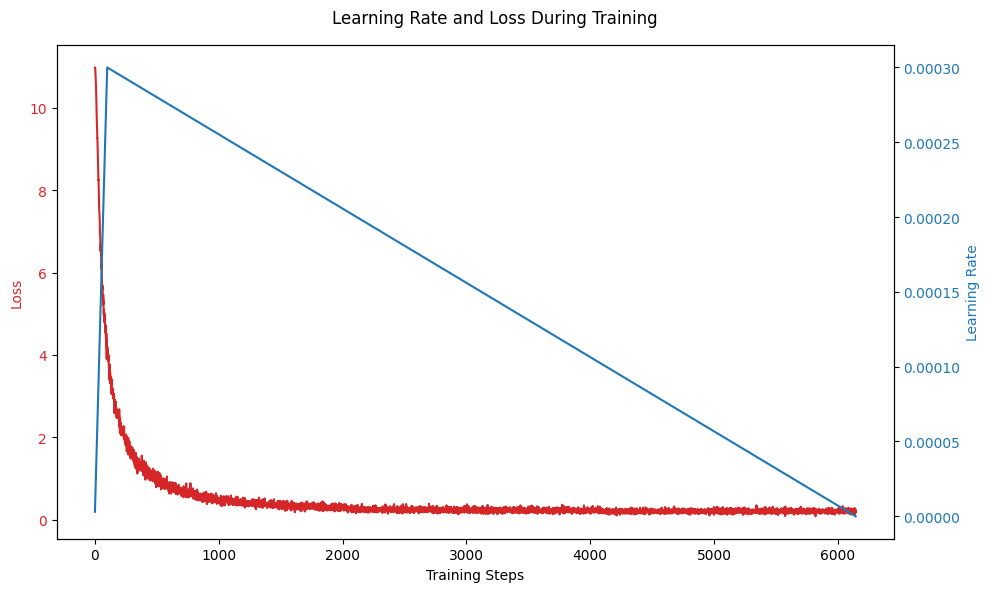

In [15]:
import matplotlib.pyplot as plt


def plot_training_metrics(loss_history, lr_history):
    """Plot learning rate and loss after training."""
    steps = range(len(loss_history))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(steps, loss_history, color='tab:red', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Plot learning rate
    ax2 = ax1.twinx()
    ax2.set_ylabel('Learning Rate', color='tab:blue')
    ax2.plot(steps, lr_history, color='tab:blue', label='Learning Rate')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.suptitle('Learning Rate and Loss During Training')
    fig.tight_layout()
    plt.show()


plot_training_metrics(loss_history, lr_history)

### Generate summary function

In [16]:
def generate_summary(model: MyTransformer, input, max_len=40):
    model.eval()
    # Ensure input is on the correct device
    input = input.to(device)

    # Get encoder output
    with torch.no_grad():
        input_padding_mask = get_padding_mask(input, input.size(1), input.size(1))  # Encoder padding mask
        encoder_output = model.encoder(input, src_mask=input_padding_mask)
        generated = torch.tensor([[tokenizer.bos_token_id]], device=device)

        for _ in range(max_len):
            # TODO: add masks
            target_padding_mask = get_padding_mask(generated, generated.size(1),
                                                   generated.size(1))  # Decoder padding mask
            target_mask = get_tgt_mask(generated) & target_padding_mask  # Decoder casual mask for target
            cross_mask = get_padding_mask(input, generated.size(1), input.size(1))  # Cross mask in Decoder

            # Get model predictions

            logits = model.decoder(
                generated, encoder_output,
                tgt_mask=target_mask,
                cross_mask=cross_mask
            )
            # Get the last predicted token (greedy decoding)
            next_token_logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size]
            # probs = F.softmax(next_token_logits, dim=-1)

            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            # next_token = torch.multinomial(probs, num_samples=1)  # Select most probable token

            # Append token to generated sequence
            generated = torch.cat([generated, next_token], dim=1)

            # Stop generating if the <EOS> token is reached
            if next_token.item() == tokenizer.eos_token_id:
                break

    # Convert token IDs to text
    summary_text = tokenizer.decode(generated.squeeze(0).tolist(), skip_special_tokens=True)
    return summary_text


### Result

In [19]:
torch.manual_seed(42)
inp = tokenizer.decode(inputs[0], skip_special_tokens=True)
# inp = "This"
print(inp[:100])
test_input = torch.tensor([tokenizer.encode(inp)], device=device)
summary = generate_summary(transformer, test_input)
print("Generated Summary:", summary)


Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as
Generated Summary:  by," D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D
